In [1]:
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.models import resnet18, resnet34
import time
import PIL
import matplotlib.pyplot as plt
# ! pip install git+https://github.com/davidbau/baukit
# ! pip install torchinfo tqdm matplotlib
# ! unzip -q flat_spectrograms.zip
# ! unzip -q train_val_test.zip

In [2]:
from baukit import show
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_path = "/scratch/monaghan.ad/data/train_val_test3/train" # "data/spectrograms/train"
# train_path = "/scratch/monaghan.ad/data/new_train_distributions/new_dist_train"
val_path = "/scratch/monaghan.ad/data/train_val_test3/val"
test_path = "/scratch/monaghan.ad/data/train_val_test3/test"
# test_path = "mnist_4440/test"
# train_set = ImageFolder(train_path)
# print("Number of images in the training set =", len(train_set))

cuda


In [3]:
# idx = 4440
# item = train_set[idx]
# print(f"{idx}th item is a pair", item)

# img, label = train_set[idx]
# show(img)
# print(f"{label=} ({train_set.classes[label]})")

In [4]:
from torchvision.transforms import (
    RandomCrop,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomRotation,
    Normalize,
)
from torchvision.transforms import v2

img_size = 256

base_augs = [
    v2.ToTensor(),
    v2.ToDtype(torch.float32),
    v2.Grayscale(num_output_channels=1),
    v2.Resize((img_size, img_size)),
    v2.Normalize(mean=[0.1723], std=[0.1165]),  # note, these values are calculated from 10k image from the training set. This should likely be a learned parameter though because different images have different sound profiles
]

train_aug = transforms.Compose(
    [
        *base_augs,
        v2.RandomAffine(degrees=0, translate=(0, 0.4)),
        # v2.RandomRotation(5),
        # v2.RandomCrop(size=256, padding=20),  # need to be weary of cutting off a lot of whales at the left side
    ]
)

/home/monaghan.ad/ml/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [5]:
from torchvision import transforms

class mapping_transform(object):
  def __init__(self, num_labels):
    self.num_labels = num_labels

  def __call__(self, labels):    
    # generate new random label
    # new_label = np.array([mapping[l] for l in labels])
    return mapping[labels]#new_label

mapping = {0: 0, 1: 0, 2: 1, 3: 3, 4: 0, 5: 2}

img_size = 256
train_set = torchvision.datasets.ImageFolder(
    train_path, 
    transform=train_aug,
    target_transform=mapping_transform(num_labels=4)#transforms.Lambda(lambda y: mapping_transform(y)),
)
no_aug_train_set = torchvision.datasets.ImageFolder(
    train_path, 
    transform=transforms.Compose([v2.ToTensor(),
    v2.ToDtype(torch.float32),
    v2.Grayscale(num_output_channels=1),
    v2.Resize((img_size, img_size)),
    v2.RandomAffine(degrees=0, translate=(0, 0.4)),]),
    target_transform=mapping_transform(num_labels=4)#transforms.Lambda(lambda y: mapping_transform(y)),
)

val_set = torchvision.datasets.ImageFolder(
    val_path, 
    transform=transforms.Compose(base_augs),
    target_transform=mapping_transform(num_labels=4)#transforms.Lambda(lambda y: mapping_transform(y)),
)

test_set = torchvision.datasets.ImageFolder(
    test_path, 
    transform=transforms.Compose(base_augs),
    target_transform=mapping_transform(num_labels=4)#transforms.Lambda(lambda y: mapping_transform(y)),
)

train_set.targets = [mapping[t] for t in train_set.targets]
val_set.targets = [mapping[t] for t in val_set.targets]
test_set.targest = [mapping[t] for t in test_set.targets]
train_set.classes = ["Background", "Fish", "Vessel", "Mn"]  # @Brandon seems like before you had Vessel at 3 and Mn at 2 but the labels were off, not sure
val_set.classes = ["Background", "Fish", "Vessel", "Mn"]
test_set.classes = ["Background", "Fish", "Vessel", "Mn"]

In [6]:
train_set.classes

['Background', 'Fish', 'Vessel', 'Mn']

In [7]:
val_set.classes

['Background', 'Fish', 'Vessel', 'Mn']

In [8]:
set(test_set.targets)

{0, 1, 2, 3, 4, 5}

0


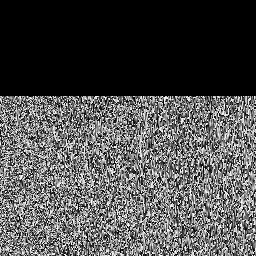

In [9]:
img, label = train_set[5000]
len(train_set), len(val_set)
# now the image is a tensor
# img.resize((3, 256, 256))
# img#.shape
# torchvision.transforms.Resize((256, 256))(img)
print(label)
transforms.functional.to_pil_image(img[0])

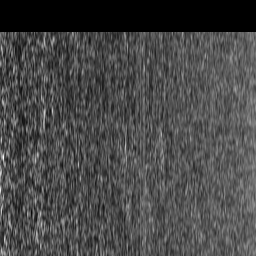

In [10]:
transforms.functional.to_pil_image(no_aug_train_set[5000][0][0])

In [11]:
# # m = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# summary(m, (1, 3, 256, 256))

In [12]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=50,
    shuffle=True,
    num_workers=24,
    pin_memory=True,
)

no_aug_train_loader = torch.utils.data.DataLoader(
    no_aug_train_set,
    batch_size=50,
    shuffle=True,
    num_workers=24,
    pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=50,
    shuffle=True,
    num_workers=24,
    pin_memory=True,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=50,
    shuffle=True,
    num_workers=24,
    pin_memory=True,
)

In [13]:
images, labels = next(train_loader.__iter__())
print(f"{images.shape=}, {labels.shape=}")

images.shape=torch.Size([50, 1, 256, 256]), labels.shape=torch.Size([50])


In [14]:
# ## Some helper functions to view network parameters
from torchinfo import summary

def view_network_shapes(model, input_shape):
    print(summary(model, input_size=input_shape))

def view_network_parameters(model):
    # Visualise the number of parameters
    tensor_list = list(model.state_dict().items())
    total_parameters = 0
    print("Model Summary\n")
    for layer_tensor_name, tensor in tensor_list:
        total_parameters += int(torch.numel(tensor))
        print("{}: {} elements".format(layer_tensor_name, torch.numel(tensor)))
    print(f"\nTotal Trainable Parameters: {total_parameters}!")

In [15]:
img[None].shape

torch.Size([1, 1, 256, 256])

In [16]:
model = resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
model.fc = nn.Linear(512, 4, bias=True)
model = model.to(device)
view_network_shapes(model, img[None].shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 4]                    --
├─Conv2d: 1-1                            [1, 64, 128, 128]         3,136
├─BatchNorm2d: 1-2                       [1, 64, 128, 128]         128
├─ReLU: 1-3                              [1, 64, 128, 128]         --
├─MaxPool2d: 1-4                         [1, 64, 64, 64]           --
├─Sequential: 1-5                        [1, 64, 64, 64]           --
│    └─BasicBlock: 2-1                   [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 64, 64]           128
│    │    └─ReLU: 3-3                    [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-4                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 64, 64]           128
│    │    └─ReLU: 3-6                    [1, 64, 64, 64]           --
│

In [17]:
model.load_state_dict(torch.load("weights5", map_location=device))

<All keys matched successfully>

In [19]:
# training the model
def train_model(model, train_loader, loss_fn, optimizer):
    model.train()
    # Initiate a loss monitor
    train_loss = []
    correct_predictions = 0
    for i, (images, labels) in enumerate(train_loader):
        if i % 100 == 0:
            print(i)
        images = images.to(device)
        labels = labels.to(device)
        # predict the class
        predicted = model(images)
        loss = loss_fn(predicted, labels)
        correct_predictions += (predicted.argmax(dim=1) == labels).sum().item()

        # Backward pass (back propagation)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    return np.mean(train_loss), correct_predictions / len(train_loader.dataset)


# evaluating the model
@torch.inference_mode()  # understand what torch.inference_mode() or torch.no_grad() does
def evaluate_model(model, val_loader, loss_fn, return_confusion_matrix=False):
    model.eval()
    # Initiate a loss monitor
    val_loss = []
    correct_predictions = 0
    all_images = []
    all_labels = []
    all_predictions = []

    if return_confusion_matrix:
        confusion_matrix = torch.zeros(
            len(val_loader.dataset.classes), len(val_loader.dataset.classes)
        )

    for images, labels in val_loader:
        all_images.append(images)
        all_labels.append(labels)
        images = images.to(device)
        labels = labels.to(device)
        # predict the class
        predicted = model(images)
        all_predictions.append(predicted.to('cpu'))
        loss = loss_fn(predicted, labels)
        correct_predictions += (predicted.argmax(dim=1) == labels).sum().item()

        if return_confusion_matrix:
            for t, p in zip(labels.view(-1), predicted.argmax(dim=1).view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

        val_loss.append(loss.item())

    val_loss = np.mean(val_loss)
    val_acc = correct_predictions / len(val_loader.dataset)

    if return_confusion_matrix:
        return val_loss, val_acc, all_images, all_labels, all_predictions, confusion_matrix
    else:
        return val_loss, val_acc, all_images, all_labels, all_predictions

In [20]:
train_set.classes

['Background', 'Fish', 'Vessel', 'Mn']

100%|██████████| 1515/1515 [00:21<00:00, 70.51it/s]


Text(0.5, 1.0, 'Distribution of Classes in Training Set')

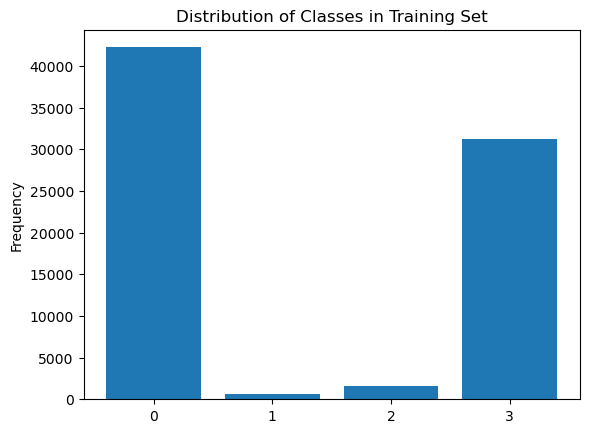

In [21]:
# plot the data distribution in the training set

from tqdm import tqdm
from matplotlib import pyplot as plt

counter = torch.zeros(len(train_set.classes))
for images, labels in tqdm(train_loader):
    for label in labels:
        counter[label] += 1

##########################################################
# **Exercise 4.2.1.2**
# TODO: Plot the distribution of classes in the training set as a bar plot
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html
plt.bar(list(range(len(counter))), counter)
plt.xticks(range(4))
plt.ylabel("Frequency")
plt.title("Distribution of Classes in Training Set")

# raise NotImplementedError

##########################################################

In [22]:
counter / sum(counter)
# ([0.2925, 0.0037, 0.0035, 0.6709, 0.0051, 0.0242])

tensor([0.5580, 0.0083, 0.0205, 0.4131])

In [23]:
weight = max(counter) / counter
weight
# weight + torch.ones(weight.shape)
# 2.7960e+00, 2.0886e+03, 1.4919e+02, 1.0000e+00, 7.7643e+01, 3.8678e+01

tensor([ 1.0000, 67.0556, 27.1847,  1.3507])

In [24]:
(max(counter) / counter) ** .5

tensor([1.0000, 8.1887, 5.2139, 1.1622])

In [25]:
(max(counter) / counter) ** .25

tensor([1.0000, 2.8616, 2.2834, 1.0781])

In [26]:
torch.manual_seed(4440)
print("resnet18 images wide model, no crop")
# model = cnn_classifier().to(device)
epochs = 0  # your model should be able to get > 98% validation accuracy on the first 10 epochs
####################################################################
# **Exercise 4.2.2.2**
# TODO: choose values for your hyperparameters
learning_rate = 0.00001 #0.005 # None
weight_decay = 0.0001 # None
# TODO: choose a loss function and optimizer
# loss_fn = torch.nn.CrossEntropyLoss(weight = ((max(counter) / counter) ** .5).to(device)) #None
loss_fn = torch.nn.CrossEntropyLoss() #None
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # None
milestones = [10, 20, 40, 70]
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

####################################################################

training_losses = []
validation_losses = []

for epoch in range(epochs):
    lr = 0
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    start_time = time.perf_counter()
    train_loss, train_acc = train_model(model, train_loader, loss_fn, optimizer)
    training_losses.append(train_loss)
    val_loss, val_acc = evaluate_model(model, val_loader, loss_fn)
    validation_losses.append(val_loss)
    scheduler.step()
    end_time = time.perf_counter()
    print(
        f"epoch: {epoch+1}/{epochs} | train loss={np.mean(train_loss):.4f}, {train_acc=:.4f} | val loss: {np.mean(val_loss):.4f}, {val_acc=:.4f} | time: {end_time-start_time:.4f} | lr: {lr}"
    )
    

resnet18 images wide model, no crop


In [27]:
# torch.save(model.state_dict(), "actual_wide_resnet")

In [28]:
# for name, param in model.named_parameters():
#     print(name, param.shape, param)

In [29]:
# torch.save(model.state_dict(), "resnet34_20epochs")

# weights 4 was with lr milestons and wd = 0.005

In [30]:
# model1 = model()
# model1.load_state_dict(torch.load("weights"))

In [47]:
len(training_losses)

20

In [31]:
def draw_confusion_matrix(confusion_matrix, labels, cmap="Blues"):
    confusion_matrix = np.array(confusion_matrix)
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    assert confusion_matrix.shape[0] == len(labels)

    fig, ax = plt.subplots(figsize=(7, 7))
    plt.imshow(confusion_matrix, cmap=cmap)

    ax.set_xticks(np.arange(len(train_set.classes)), labels)
    ax.set_yticks(np.arange(len(train_set.classes)), labels)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right")

    for true_label in range(len(train_set.classes)):
        for pred_label in range(len(train_set.classes)):
            ax.text(
                pred_label,
                true_label,
                int(confusion_matrix[true_label, pred_label]),
                ha="center",
                va="center",
                color="black",
            )

    fig.tight_layout()
    plt.show()

In [21]:
confusion_matrix

NameError: name 'confusion_matrix' is not defined

val_loss=0.30325319298676084, val_acc=0.89625520110957


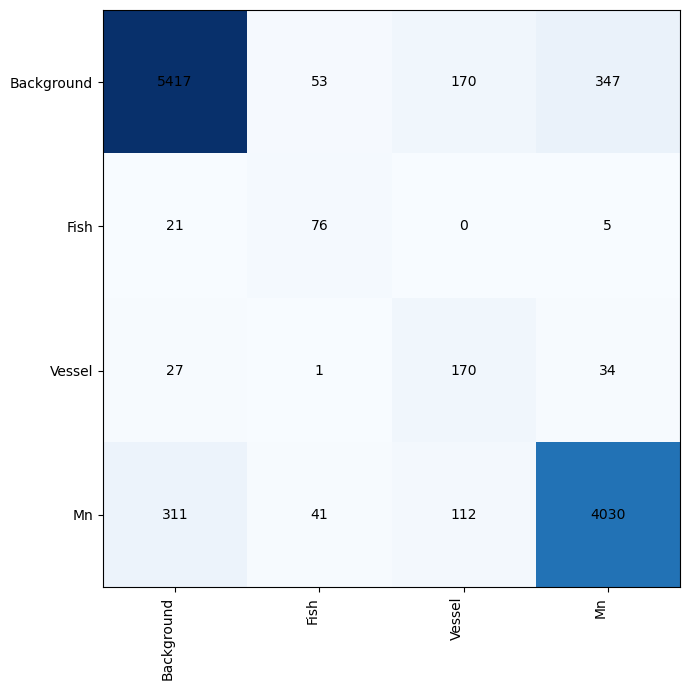

In [32]:
val_loss, val_acc, imgs, labels, preds, confusion_matrix = evaluate_model(
    model, val_loader, loss_fn, return_confusion_matrix=True
)
print(f"{val_loss=}, {val_acc=}")
draw_confusion_matrix(confusion_matrix, train_set.classes)

test_loss=0.3035252532528124, test_acc=0.8949655586889187


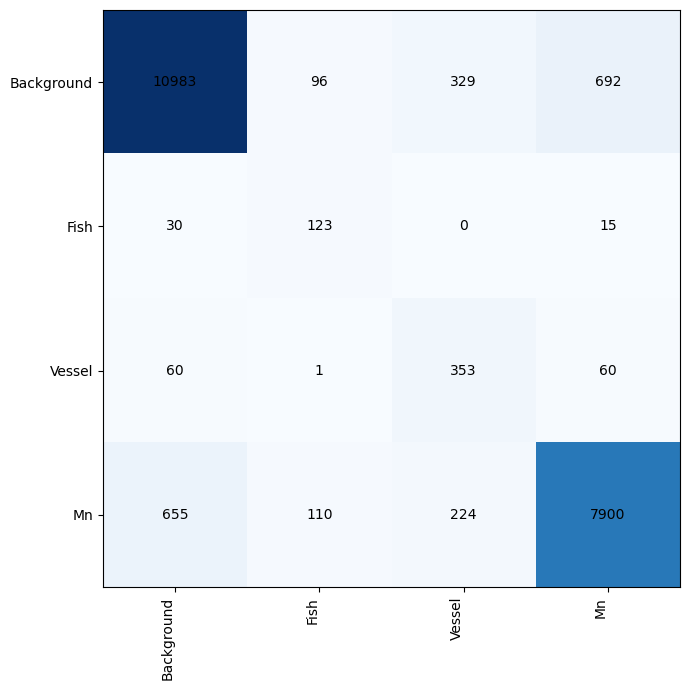

In [33]:
test_loss, test_acc, imgs, labels, preds, confusion_matrix = evaluate_model(
    model, test_loader, loss_fn, return_confusion_matrix=True
)
print(f"{test_loss=}, {test_acc=}")
draw_confusion_matrix(confusion_matrix, train_set.classes)

train_loss=0.36181418266725224, train_acc=0.8698236576183872


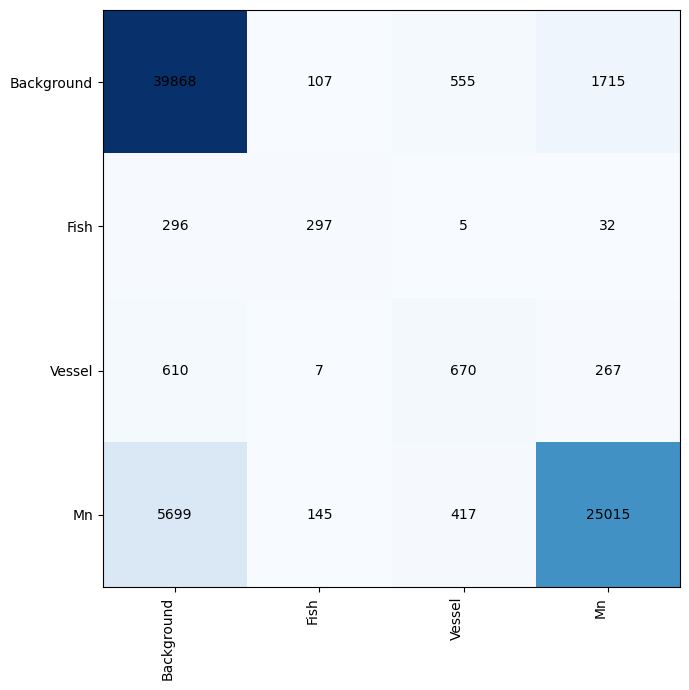

In [34]:
train_loss, train_acc, imgs, labels, preds, confusion_matrix = evaluate_model(
    model, train_loader, loss_fn, return_confusion_matrix=True
)
print(f"{train_loss=}, {train_acc=}")
draw_confusion_matrix(confusion_matrix, train_set.classes)